# The exponential kernel.

## Functional Methods in Machine Learning 
Final exam

Due date: Monday, 2022/03/07, 13:00


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from numpy.random import default_rng
from sklearn.gaussian_process.kernels import RBF


import kernel_approximation as ka
import kernel_machine_learning as kml
import stochastic_plots as stoch

## Generation of random samples: Inverse transform sampling.

Consider a real-valued random variable whose pdf is $f(x)$. 
The corresponding cdf is
$$
F(x) = \int_{-\infty}^{x} dx' f(x').
$$
This inverse of the cdf ($F^{-1}(p)$) can be used to generate random numbers from this distribution using the following algorithm:

1. Generate a sample from the $U[0,1]$ distribution $\left\{u_m \right\}_{m=1}^M $ with $ u_m \sim U[0,1]$.
2. The sample $\left\{w_m = F^{-1}(u_m) \right\}_{m=1}^M $ is such that $w_m \sim f(w)$. 

For instance, the pdf of an exponential distribution defined on the set of non-negative real numbers is
$$
f(x) = \lambda e^{-\lambda x},   x \ge 0,
$$
with $\lambda > 0$.

The corresponding cdf is
$$
F(x) = \int_{0}^{x} dx \lambda e^{-\lambda x} = 1 - e^{-\lambda x}, \  x \ge 0.
$$
The inverse of the cdf is such that $ F^{-1}(p) = x$.
Since $p = F(x) = 1 -e^{-\lambda x}$, $x = - \log (1-p) / \lambda$. Therefore, 
$$
F^{-1}(p) = -\frac{1}{\lambda} \log (1-p), \ 0 \le p \le 1.
$$
See, for instance, [ https://en.wikipedia.org/wiki/Exponential_distribution ]

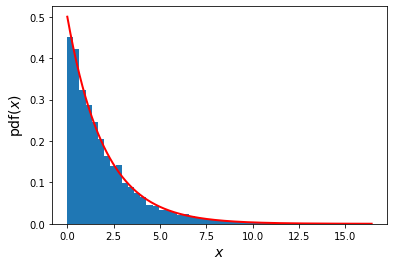

In [2]:
# Generate samples from the exponential distribution.

# Exponential distribution
def exp_pdf(x, gamma):
    return  np.exp(- x / gamma) / gamma

def exp_cdf(x, lambd):
    return 1.0 - np.exp(- x / gamma)

def exp_inverse_cdf(p, gamma):
    return - gamma * np.log(1.0 - p) 

# Inverse transform sampling.

gamma = 2.0

n_samples = 10000
rng = default_rng(12345)
U = rng.random(n_samples) # U ~ U[0, 1]
X = exp_inverse_cdf(U, gamma)

# Define a range for the plot. 


fontsize = 14
fig, ax = stoch.plot_pdf(
    X, 
    lambda x: exp_pdf(x, gamma), 
    fontsize=fontsize, 
    fig_num=1,
)
_ = ax.set_xlabel('$x$', fontsize=fontsize)
_ = ax.set_ylabel('pdf($x$)', fontsize=fontsize)

## Exponential kernel in 1 dimension

The exponential kernel in 1 dimension is
$$
k(x, x') = k(x - x') = \exp\left(- \frac{\left|x - x' \right|}{\gamma} \right).
$$

####  Q1. Express this kernel as the Fourier transform of a density $\hbox{pdf}(x)$.
$$
k(x) = \int_{-\infty}^{\infty} e^{i w x} \text{pdf}(w) dw.
$$
The density is proportional to the  the inverse Fourier transform of $k(x)$
$$
\hbox{pdf}(w) = \frac{1}{2 \pi} \int_{-\infty}^{\infty} e^{-i x w} k(x) dx 
$$

**Answer.-**

Since we already know the expression of the required pdf and we know the expression of the kernel, we can use the kernel expression in the pdf:
\begin{align*}
pdf(w) = \frac{1}{2\pi} \int_{-\infty}^{\infty} e^{-i x w} k(x) dx = \frac{1}{2\pi} \int_{-\infty}^{\infty} e^{-i x w} e^{- \frac{|x|}{\gamma}} dx
\end{align*}
To *get rid of the* absolute value, we can split the integral between $\mathbb R^+$ and $\mathbb R^-$.
\begin{align*}
\frac{1}{2\pi} \int_{-\infty}^{\infty} e^{-i x w} e^{- \frac{|x|}{\gamma}} dx  & = 
\frac{1}{2\pi}\left( \int_{-\infty}^{0} e^{-i x w} e^{ \frac{x}{\gamma}} dx \int_{0}^{+\infty} e^{-i x w} e^{ \frac{-x}{\gamma}}dx \right)\\
& \stackrel{(1)}{=} \frac{1}{2\pi}\left( \int_{-\infty}^{0} e^{ x \big( -iw + \frac{1}{ \gamma } \big) } dx + \int_{0}^{+\infty} e^{ x \big( -iw - \frac{1}{ \gamma } \big) } dx\right)\\
& = \frac{1}{2\pi}\left( \left[\frac{ e^{-iwx} e^{\frac{x}{\gamma}} }{-iw +\frac{1}{\gamma}}\right]_{-\infty}^{0} + \left[\frac{ e^{-iwx} e^{\frac{-x}{\gamma}} }{-iw -\frac{1}{\gamma}}\right]_{0}^{+\infty}\right)
\end{align*}
where, in $(1)$, we have used that the integral of the exponential is straightforward. Now, we have to recall that
$$
e^{-iwx} = cos(-wx) + i sin(-wx),
$$
and, thus, this term is bounded. Using this, we obtain that the limit of the terms containing exponentials is zero, that is:
\begin{align*}
\frac{1}{2\pi}\left( \left[\frac{ e^{-iwx} e^{\frac{x}{\gamma}} }{-iw +\frac{1}{\gamma}}\right]_{-\infty}^{0} + \left[\frac{ e^{-iwx} e^{\frac{-x}{\gamma}} }{-iw -\frac{1}{\gamma}}\right]_{0}^{+\infty}\right) & = 
\frac{1}{2\pi}\left( \left[\frac{1}{-iw + \frac{1}{\gamma}} - \lim_{x \to -\infty} \frac{ e^{-iwx} e^{\frac{x}{\gamma}} }{-iw + \frac{1}{\gamma}}\right] + \left[\frac{1}{-iw - \frac{1}{\gamma}} - \lim_{x \to +\infty} \frac{ e^{-iwx} e^{\frac{-x}{\gamma}} }{-iw - \frac{1}{\gamma}}\right]\right) \\
& = \frac{1}{2\pi} \left( \frac{1}{-iw + \frac{1}{\gamma}} - \frac{1}{-iw - \frac{1}{\gamma}} \right) \\
& = \frac{1}{2\pi} \left( \frac{(-iw - \frac{1}{\gamma}) - (-iw + \frac{1}{\gamma})}{(-iw + \frac{1}{\gamma})(-1)(iw + \frac{1}{\gamma})}  \right) \\
& = \frac{1}{\pi} \left( \frac{-\frac{1}{\gamma}}{-w^2 - \frac{1}{\gamma^2} } \right)\\
& = \frac{1}{\pi} \frac{\gamma}{1 + w^2 \gamma^2}.
\end{align*}

Until now, we have obtained that 
$$
pdf(w) = \frac{1}{\pi} \frac{\gamma}{1 + w^2 \gamma^2}.
$$
Now, if we rename $\gamma = \frac{1}{\gamma}$ which we can do, since we have no restrictions for gamma, we obtain that the $pdf(w)$ has the form:
$$
pdf(w) = \frac{1}{\pi}\frac{1}{\gamma \left(1 + \left( \frac{w}{\gamma}\right)^2\right)},
$$
which is the form of the pdf of a [Cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution). Using this, we can be sure that this pdf is normalized and this is the pdf that we were searching for. 

Recall that the cauchy distribution has two parameters, that is, $f(x; x_0, \gamma_c)$. In our case, $x_0 = 0$ and $\gamma_c = \frac{1}{\gamma}$.
  
  
####  Q2. Derive the cdf and inverse of the cdf for $\hbox{pdf}(w)$. 
The corresponding cumulative distribution function is:
$$
\hbox{cdf}(w) = \int_{-\infty}^w \hbox{pdf}(w') dw'
$$
 
**Answer.-**

The answer to this question is immediate since the CDF of a Cauchy distribution is defined. If we use our $x_0$ and $\gamma_c$, the expression is:
$$
F\left(x; 0,\frac{1}{\gamma}\right)=\frac{1}{\pi} \arctan\left(\gamma x\right)+\frac{1}{2}
$$

Now, we have to give an expression for the inverse of the CDF $F$. This is straightforward since we know that the [quantile](https://en.wikipedia.org/wiki/Quantile_function), if the function $F$ is continuous and strictly monotonically increasing (as in this case, since it is a CDF), is the inverse of the CDF. Hence, 
$$
F^{-1}\left(p;0, \frac{1}{\gamma}\right) =  \frac{1}{\gamma} \,\tan\left[\pi \left(p-{\frac {1}{2}}\right)\right]
$$

#### Q3. Use the method of the inverse to generate random numbers sampled from this $\text{pdf}(w)$.


Although we gave the definition of the pdf that matches the definition of the Cauchy distribution, we will use the first pdf expression found:
$$
pdf(w) = \frac{1}{\pi} \frac{\gamma}{1 + w^2 \gamma^2}.
$$

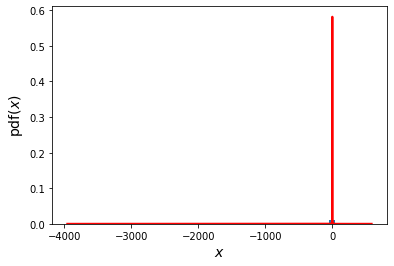

In [3]:
def cauchy_pdf(x, gamma):
    return  (1/np.pi) * (gamma/(1 + (x*gamma)**2))

def cauchy_cdf(x, gamma):
    return (1/np.pi) *np.arctan(gamma*x) + 0.5

def cauchy_inverse_cdf(p, gamma):
    return (1/gamma)* np.tan(np.pi*(p-0.5))

# Inverse transform sampling.
gamma = 2.0

n_samples = 10000
rng = np.random.default_rng(12345)
U = rng.random(n_samples)
X = cauchy_inverse_cdf(U,gamma)

fontsize = 14
fig, ax = stoch.plot_pdf(
    X, 
    lambda x: cauchy_pdf(x,gamma),
    fontsize=fontsize, 
    fig_num=1,
)
_ = ax.set_xlabel('$x$', fontsize=fontsize)
_ = ax.set_ylabel('pdf($x$)', fontsize=fontsize)



We see that the plot is really sparse. This, however, **makes sense** since the tangent function goes to $+ \infty$ when the argument tends to $\pi/2$ and goes to $-\infty$ when the argument tends to $-pi/2$, so we have many points that are outliers. A possible solution could be to clip the values to an interval. 

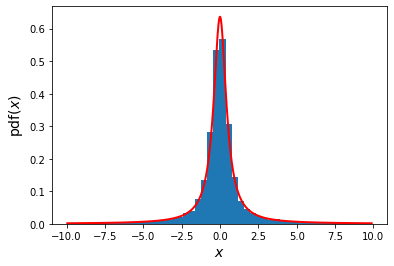

In [4]:

thresh = 10
X_threshed = X[np.abs(X) < thresh]

fontsize = 14
fig, ax = stoch.plot_pdf(
    X_threshed, 
    lambda x: cauchy_pdf(x,gamma),
    fontsize=fontsize, 
    fig_num=1,
)
_ = ax.set_xlabel('$x$', fontsize=fontsize)
_ = ax.set_ylabel('pdf($x$)', fontsize=fontsize)

## Exponential kernel in $D$ dimensions.

Consider the exponential kernel in $D$ dimensions
$$ k(\mathbf{x}, \mathbf{x}') = k(\mathbf{x}- \mathbf{x}') = \exp\left\{- \frac{\lVert \mathbf{x}- \mathbf{x}' \rVert_1}{\gamma} \right\},$$
with the $L_1$ norm
$$ \lVert \mathbf{x}- \mathbf{x}' \rVert_1 = \sum_{d=1}^D \left|x_d \right|.$$

The Fourier transform of the exponential kernel in $D$ dimensions is proportional to a pdf:
$$
\text{pdf}(\mathbf{w}) \propto \int_{\mathbb{R}^D} e^{-i \mathbf{w}^T \mathbf{x}} \exp\left\{- \frac{\lVert \mathbf{x} \rVert_1}{\gamma} \right\} d \mathbf{x}.
$$

#### Q4. Compute the Fourier transform of the exponential kernel in $D$ dimensions.
The inverse Fourier transform of a translationally invariante kernel
$$
k(\mathbf{x}, \mathbf{x}') = k(\mathbf{x} - \mathbf{x}').
$$
is
$$
\text{pdf}(\mathbf{w}) = \frac{1}{\left(2 \pi\right)^D} \int_{\mathbb{R}^D} e^{- i \mathbf{w}^T \mathbf{x}} k(\mathbf{x}) d\mathbf{x}
$$

**Answer.-**


Firstly, recall that since $\mathbf{w,x} \in \mathbb R^D$, $\mathbf{w}^T \mathbf{x} = \sum_{i=1}^D w_ix_i$.

We have been told that the F.T. is proportional to a p.d.f. 

Let us expand the RHS of the expression to which the pdf is proportional:

\begin{align*}
\int_{\mathbb{R}^D} e^{-i \mathbf{w}^T \mathbf{x}} \exp\left\{- \frac{\lVert \mathbf{x} \rVert_1}{\gamma} \right\} d \mathbf{x}
& = \int_{\mathbb{R}} \cdots \int_{\mathbb{R}} \exp \left\{-i \sum_{i=1}^D x_i w_i\right\} \exp \left\{ \frac{-1}{\gamma} \sum_{i=1}^D |x_i| \right\} dx_1 \cdots dx_D \\
& = \int_{\mathbb{R}} \cdots \int_{\mathbb{R}}  \left( \exp \left \{ -i w_1 x_1  - \frac{|x_1|}{\gamma} \right\} \cdots \exp \left \{ -i w_D x_D  - \frac{|x_D|}{\gamma} \right\} \right) dx_1 \cdots dx_D
\end{align*}
It can be appretiated that each integral only depends on one of the terms, so we can express that integral as the product of the integrals.
\begin{align*}
\int_{\mathbb{R}} \cdots \int_{\mathbb{R}}  \left( \exp \left \{ -i w_1 x_1  - \frac{|x_1|}{\gamma} \right\} \cdots \exp \left \{ -i w_D x_D  - \frac{|x_D|}{\gamma} \right\} \right) dx_1 \cdots dx_D 
& = \prod_{i=1}^D \int_{\mathbb R} \exp \left \{ -i w_D x_D  - \frac{|x_D|}{\gamma} \right\} dx_i
\end{align*}
Lastly, we only have to see that each of the integrals is the one that we did previously in dimension $1$ in the question **Q1**. Hence, we obtain:
\begin{align*}
\int_{\mathbb{R}^D} e^{-i \mathbf{w}^T \mathbf{x}} \exp\left\{- \frac{\lVert \mathbf{x} \rVert_1}{\gamma} \right\} d \mathbf{x} = \prod_{i=1}^D pdf(w_i)
\end{align*}
Clearly, due to the normalization of the single pdfs, this is normalized and we obtain that the proportional expression is, in fact, an equality:
$$
\text{pdf}(\mathbf{w}) = \prod_{i=1}^D \text{pdf}(w_i)
$$

#### Q5. Use the method of the inverse to generate random numbers sampled from $\text{pdf}(\mathbf{w})$.

*Hint:* If the 1D implementation is vectorized, the answer to this question is straightforward.

Our previous implementation was vectorized, so the only difference is to create the samples from the uniform with the shape $(n\_samples,D)$. To be able to plot as we did before, we keep the first dimension and plot the histogram and pdf for this dimension. We decide to apply the threshold as we did before, since we found that the same outlier problem was occurring.

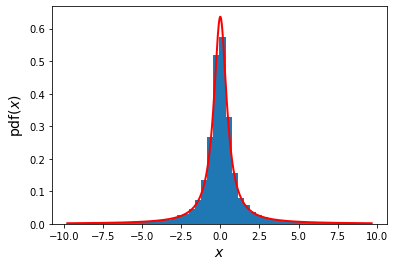

In [17]:
# Inverse transform sampling.
gamma = 2.0
n_samples = 10000
D = 100
rng = np.random.default_rng(12345)
U = rng.random((n_samples,D))
X = cauchy_inverse_cdf(U,gamma)

thresh = 10
X0_threshed = X[:,0][np.abs(X[:,0]) < 10]



fontsize = 14
fig, ax = stoch.plot_pdf(
    X0_threshed, 
    lambda x: cauchy_pdf(x,gamma),
    fontsize=fontsize, 
    fig_num=1,
)
_ = ax.set_xlabel('$x$', fontsize=fontsize)
_ = ax.set_ylabel('pdf($x$)', fontsize=fontsize)


In [18]:
X0,X1 = X[:,0],X[:,1]
thresh = 5
X_threshed = np.array([[X0[i],X1[i]] for i in range(len(X0)) if np.abs(X0[i]) < thresh and np.abs(X1[i]) < thresh])

def bin_centers(bins):
    centers = (bins + (bins[1]-bins[0])/2) [:-1]    
    return centers

fig = plt.figure()
h = np.histogram2d(X_threshed[:,0], X_threshed[:,1], bins=50)
df = pd.DataFrame(h[0]/len(h[0]), index=bin_centers(h[1]), columns=bin_centers(h[2]))
fig = go.Figure(data=[go.Surface(z=df)])
_ = fig.show()

<Figure size 432x288 with 0 Axes>

#### Q6. Write code to generate random Fourier Features corresponding to the exponential kernel in D dimensions.

Complete the code for the class 

```python
class RandomFeaturesSamplerExp(RandomFeaturesSampler):
```
in the file 
``` 
kernel_approximation.py
```

**Answer.-**

After implementing the code neede in the `RandomFeaturesSamplerExp` class, we will perform a little example on how this class approximates the kernel.

Firstly, we generate data using the datasets from `sklearn`. We also plot it.

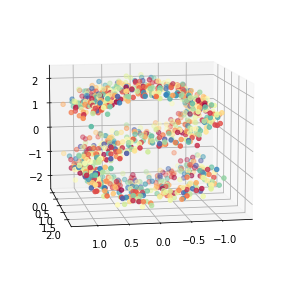

In [19]:
## Generate data
X,t = ka.generate_curve_dataset(1000)
ka.plot_curve_dataset(X,t)

After implementing the class in `kernel_approximation.py`, we plot the approximation for a range of different number of sampled features. We compare it with the original kernel using the function `demo_kernel_approximation_features`.

# of random features =  10
# of random features =  100
# of random features =  1000
# of random features =  10000


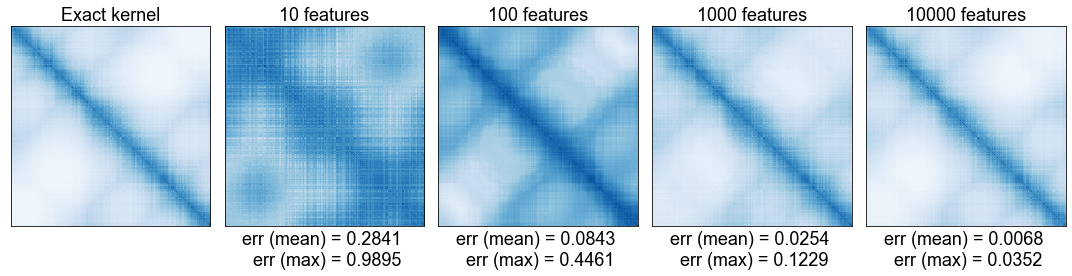

In [8]:
n_features = np.array([10**i for i in range(1,5)])
length_scale_kernel = 2.0
RFExpSamplers = [ka.RandomFeaturesSamplerExp(n_features_sampled = n_feats,
                                             length_scale_kernel = length_scale_kernel)
                                            for n_feats in n_features]



ka.demo_kernel_approximation_features(
    X = X,
    kernel = kml.exponential_kernel,
    features_samplers = RFExpSamplers)

We know that using random features, we are approximating the kernel the following way:
\begin{align*}
k(\mathbf{x} - \mathbf{x'}) & = \int_{\mathbb R^D} p(\mathbf{w})\left(cos(\mathbf{w}^t \mathbf{x}) \ \ sin(\mathbf{w}^t \mathbf{x})\right) \begin{pmatrix} cos(\mathbf{w}^t \mathbf{x'}) \\ sin( \mathbf{w}^t \mathbf{x'})\end{pmatrix} d \mathbf{w} \\ 
& \approx \sum_{j = 1}^J \left(cos(\mathbf{w}^t \mathbf{x}) \ \ sin(\mathbf{w}^t \mathbf{x})\right) \begin{pmatrix} cos(\mathbf{w}^t \mathbf{x'}) \\ sin( \mathbf{w}^t \mathbf{x'})\end{pmatrix}
\end{align*}
which is a **Monte Carlo** approximation. We know that the Monte Carlo approximation has an error $O\left(1/\sqrt{n}\right)$. Let us draw the approximation error with a wider range of sampled features, along with the function $f(n) = \frac{1}{\sqrt{n}}$ for each number of features to see if our approximation error converges to this function.

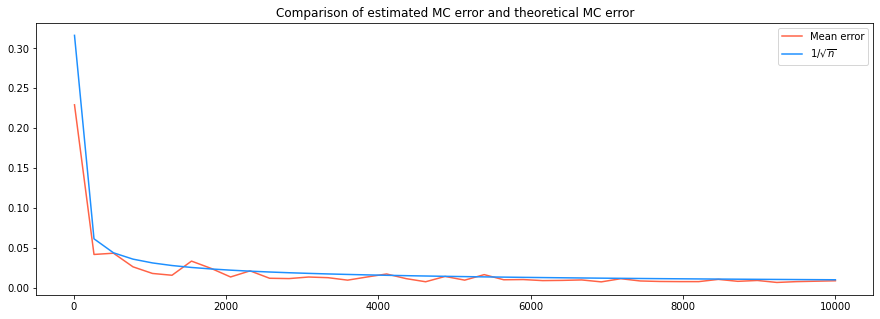

In [23]:
n_features = np.linspace(10,10000,40,dtype = int)
length_scale_kernel = 2.0
RFExpSamplers = [ka.RandomFeaturesSamplerExp(n_features_sampled = n_feats,
                                             length_scale_kernel = length_scale_kernel)
                                            for n_feats in n_features]

ka.plot_kernel_approximation_error(
    X = X,
    kernel = kml.exponential_kernel,
    features_samplers = RFExpSamplers,
    n_features = n_features,
    error_function = lambda x : 1.0/np.sqrt(x))

### Generation of Random Fourier Features: Alternative sampling scheme.

Consider the translationally invariant kernel $k\left(\mathbf{x}, \mathbf{x}'\right) = k\left(\mathbf{x} - \mathbf{x}'\right)$, with $\mathbf{x}, \mathbf{x}' \in \mathbb{R}^D$.

Acording to Bochner's theorem, this type of kernel can be expressed as the Fourier transform of a (possibly not normalized) density $p(\mathbf{w})$
$$
k\left(\mathbf{x} - \mathbf{x}'\right) = \int_{-\infty}^{\infty} d\mathbf{w} p\left(\mathbf{w}\right) e^{i \mathbf{w}^T \left(\mathbf{x} - \mathbf{x}'\right)}.
$$
Since the kernel funtion is real and symmetric, this expression can be written as 
$$
k\left(\mathbf{x} - \mathbf{x}'\right) = \int_{-\infty}^{\infty} d\mathbf{w} p\left(\mathbf{w}\right) \cos \left(\mathbf{w}^T \left(\mathbf{x} - \mathbf{x}'\right) \right).
$$

Show that the set of random features
$$
\left\{ \left( \cos \mathbf{w}^T \mathbf{x}, \sin \mathbf{w}^T \mathbf{x} \right); \mathbf{w} \sim p(\mathbf{w})\right\}.
$$
and the set 
$$
\left\{\sqrt{2} \cos \left(\mathbf{w}^T \mathbf{x} + b \right); \ \mathbf{w} \sim p(\mathbf{w}); \ b \sim U[0 , 2 \pi]; \ \mathbf{w} \perp b\right\}
$$
provide the same approximation of the kernel.

\begin{align*}
k\left(\mathbf{x}, \mathbf{x}'\right) & = \int_{-\infty}^{\infty} d\mathbf{w} p(\mathbf{w}) \left( \cos \mathbf{w}^T \mathbf{x}, \, \sin \mathbf{w}^T \mathbf{x} \right) \left( \cos \mathbf{w}^T \mathbf{x}', \, \sin \mathbf{w}^T \mathbf{x}' \right)^T \\
& = \int_{-\infty}^{\infty} d\mathbf{w} p(\mathbf{w}) \left( \cos \mathbf{w}^T \mathbf{x}  \, \cos \mathbf{w}^T \mathbf{x}' + \sin \mathbf{w}^T \mathbf{x} \,  \sin \mathbf{w}^T \mathbf{x}' \right)\\
& = \int_{-\infty}^{\infty} d\mathbf{w} p(\mathbf{w}) \cos \left( \mathbf{w}^T \left( \mathbf{x} - \mathbf{x}' \right) \right).
\end{align*}

#### Q7. Derive the kernel approximation using the second type of features.



**Answer.-**

In the previous approximation using sines and cosines, the approximation ends expressing the kernel as the product of feature mappings $\left(\hat{\phi_J(\mathbf{x})}\right)^T \hat{\phi_J(\mathbf{x'})}$

For this case, consider the following feature mapping:
$$
\phi(\mathbf{x}) = \sqrt{2}cos(\mathbf{w}^T \mathbf{x} + b)
$$
We would like to see that, if we take the expectation in both $w$ and $b$, we obtain the same approximation to the kernel. 
That is, in virtue of Bochner's theorem:
$$
k(\mathbf{x}-\mathbf{x'}) = \mathbb E{\mathbf{w},b}\left[ \phi(\mathbf{x})^T \phi(\mathbf{x})\right]
$$
Recall that the domain of $\mathbf{w}$ is $\mathbb R^D$ and the domain of $b$ is $[0,2\pi]$, but we will write the letters for convenience. Let us see this:
\begin{align*}
 \mathbb E{\mathbf{w},b}\left[ \phi(\mathbf{x})^T \phi(\mathbf{x'})\right] &  = \int_{\mathbf{w}} \text{pdf}(\mathbf w)\int_{b} \text{pdf}(b) \left(\sqrt{2}cos(\mathbf{w}^T \mathbf{x} + b) \sqrt{2}cos(\mathbf{w}^T \mathbf{x'} + b)\right) db \ d\mathbf{w}\\
 & \stackrel{(1)}{=} \frac{1}{2\pi}\int_{\mathbf{w}}\text{pdf}(\mathbf w)\int_{b} \left(cos(\mathbf{w}^T(\mathbf{x}-\mathbf{x'})) - cos(\mathbf{w}^T(\mathbf{x+x'}) + 2b)\right) db d\mathbf{w}\\
 & \stackrel{(2)}{=}  \frac{1}{2\pi}\int_{\mathbf{w}}\text{pdf}(\mathbf w)\left(cos(\mathbf{w}^T(\mathbf{x}-\mathbf{x'})\right)\int_{b}  db \ d\mathbf{w}\\
 & = \int_{\mathbf{w}}\text{pdf}(\mathbf w)\left(cos(\mathbf{w}^T(\mathbf{x}-\mathbf{x'})\right) d \mathbf{w}\\
 & = k(\mathbf{x-x'})
\end{align*}

Where, in $(1)$ we have used that 
$$
cos(a)cos(b) = \frac{1}{2}\left[cos(a+b) - cos(a-b)\right],
$$
and, in $(2)$ we have used that the [integral](https://www.wolframalpha.com/input?i=integrate+cos%28a+%2B+2x%29+between+0+and+2*pi) 
$$
\int_0^{2\pi} cos(a + 2x) dx = 0.
$$

Hence, we have obtained that both sets of random features produce the **same approximation** of the kernel.

#### Q8. Implement the sampling method based on the second type of random features.

Fill in the corresponding code in the file 
``` 
kernel_approximation.py
```

**Answer.-**

To code this, we have to simply provide an expression for the random features and its **normalization factor**. 

- For the random features, we have to sample $J$ (which in the code is `self._n_random_samples_w`) samples from the $U(0,2\pi)$ and, then, obtain the features using the previously computed `w` and the data.
- The normalization factor is $\sqrt{\frac{2}{J}}$. Lets us show this:

#### Q9. Illustrate that both types of feaures approximate the exponential kernel when $p(\mathbf{w})$ is the inverse Fourier transform of the exponential kernel in $D$ dimensions. 

We have already plotted the approximations to the kernel given by the `sin+cos` implementation. However, it is interesting to plot it again right above the approximations given by the `cos` approximations just to compare them.

Sin + Cos Sampler


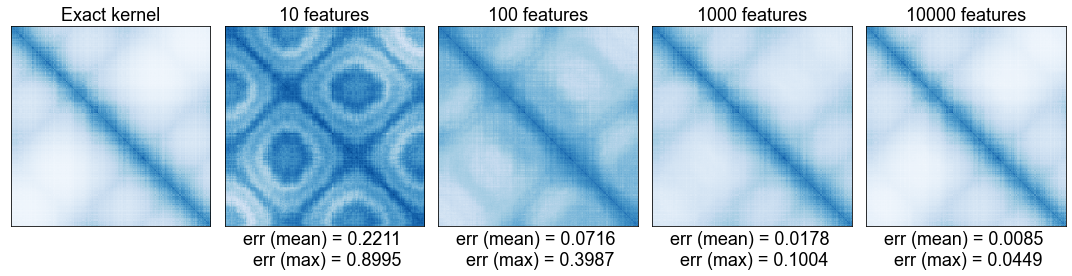

Cos Sampler


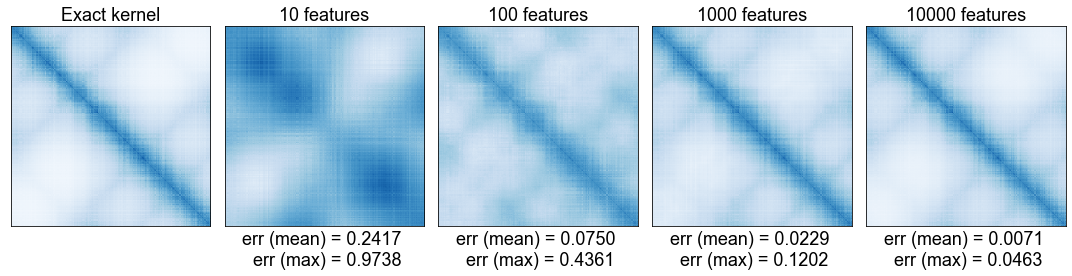

In [28]:
# Approximate the exponential kernel using Random Fourier Features.

length_scale = 2.0
A = 1.0
n_features = np.array([10**i for i in range(1,5)])

def kernel(X, Y): 
    return kml.exponential_kernel( X, Y, A=1.0, l=length_scale)

n_features = np.array([10**i for i in range(1,5)])
length_scale_kernel = 2.0
RFExpSamplersSinCos = [ka.RandomFeaturesSamplerExp(
                                                n_features_sampled = n_feats,
                                                sampling_method = 'sin+cos',
                                                length_scale_kernel = length_scale)
                                    for n_feats in n_features]

RFExpSamplersCos = [ka.RandomFeaturesSamplerExp(
                                                n_features_sampled = n_feats,
                                                sampling_method = 'cos',
                                                length_scale_kernel = length_scale)
                                    for n_feats in n_features]


print("Sin + Cos Sampler")
ka.demo_kernel_approximation_features(
    X = X,
    kernel = kml.exponential_kernel,
    features_samplers = RFExpSamplersSinCos)

print("Cos Sampler")
ka.demo_kernel_approximation_features(
    X = X,
    kernel = kml.exponential_kernel,
    features_samplers = RFExpSamplersCos)

As we can see, in both cases the original exact kernel is approximated very accurately, decreasing the mean and max error when the number of features increases. Furthermore, the mean errors do not differ in more than $0.05$ in any number of features.

### Q10. Train and evaluate different classifiers.

Solve the classification problem using different kernel methods using the same data in

https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_approximation.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-approximation-py

**To get more stable results, the process should be repeated for $10$ different random train / test partitions of the data.**

Using 5-fold cross validation on the training data, determine the optimal values of the hyperparameter for the following cases: 
1. Non-linear SVM + RBF kernel [C, gamma]
2. Linear SVM + RBF random features [C, gamma, n_features]
3. Linear SVM + RBF Nyström features [C, gamma, n_features]
4. Non-linear SVM + exponential kernel [C, length_scale] 
5. Linear SVM + exponential random features [C, length_scale, n_features]
6. Linear SVM + exponential Nyström features [C, length_scale, n_features]

##### NOTES
* Determine the hyperparameter grid on which the search is made using references from the literature. Include those references in the Chicago citation format ( https://www.chicagomanualofstyle.org/tools_citationguide/citation-guide-2.html).

* It may be useful to vary one of the hyperparameters while keeping the other fixed (include those plots in your report). For instance, for $n_{features}$. 

##### REPORT:
* Plot the curve that traces the dependence of the CV, training and test error as a function of $n_{features}$ for a fixed value of the other parameters.
* Train final models with the values of the optimal hyperparameters.  
* Provide in a table the mean and the standard deviation of the training error, the cross-validation error and test error for each of the 6 methods considered.
* Provide in a table the mean and the standard deviation of the times for the cross-validation step, for the final training time, and for the prediction time in the test set. To this end, use the Python library $\texttt{timeit}$.

### Sklearn resources.

1. Non-linear SVM for classification: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

2. Linear SVM for classification: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

3. Cross-validation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

4. Timing and accuracy plots for random Fourier Features and Nyström features: https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html